In [129]:
import numpy as np
import pandas as pd
import glob

In [188]:
all_files = glob.glob("../data/MK/PM10/*")

In [189]:
df = pd.concat((pd.read_csv(f) for f in all_files))

In [190]:
df["new_dt"] = pd.to_datetime(df["DatetimeBegin"])

In [195]:
df_min = df[(pd.DatetimeIndex(df["new_dt"]).year == 2014) & (pd.DatetimeIndex(df["new_dt"]).month == 12)]

In [198]:
df_min[df_min["Concentration"] > 2].AirQualityStationEoICode.unique()

array(['MK0030A', 'MK0031A', 'MK0034A', 'MK0035A', 'MK0037A', 'MK0040A',
       'MK0041A', 'MK0042A', 'MK0043A', 'MK0044A', 'MK0045A', 'MK0047A',
       'MK0048A'], dtype=object)

In [197]:
df_min["Concentration"].describe()

count    8467.000000
mean      100.852941
std       111.667599
min         0.000000
25%        30.400000
50%        66.300000
75%       132.300000
max       994.300000
Name: Concentration, dtype: float64

In [2]:
import time
import datetime

In [237]:
avg = pd.read_csv("avg.csv", names=['Countrycode', 'Pollutant', 'Year', 'Month', 'Value'])

In [238]:
avg = avg[(avg["Pollutant"] == "SO2")]

In [239]:
avg["Value"].describe()

count    2624.000000
mean        5.651595
std         7.033979
min         0.307367
25%         2.119189
50%         3.479118
75%         6.796876
max       117.352376
Name: Value, dtype: float64

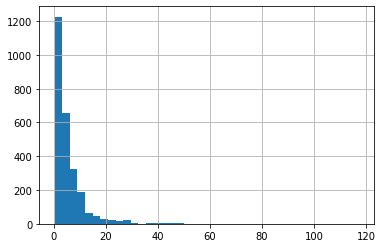

In [240]:
avg["Value"].hist(bins=40)

In [220]:
avg[avg["Value"] > 100]

,Countrycode,Pollutant,Year,Month,Value
1323,BA,SO2,2016,12,117.352376
1324,BA,SO2,2017,1,112.893961


In [83]:
area = pd.read_csv("../area.csv")

In [84]:
aya = pd.merge(area, avg, on="Countrycode")

In [85]:
import folium

In [87]:
import json
with open("../json_data/world-countries.json", "r") as world_json:
    countries = json.load(world_json).get("features")

In [90]:
color_scale = np.array(['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58'])
bin_edges = np.linspace(200, 1600, 8)

def color_coding(value):    
    idx = np.digitize(value, bin_edges, right=True)
    return color_scale[idx]

In [91]:
aya["Color"] = aya["Value"].apply(color_coding)

In [92]:
geo_dict = {}
for country in countries:
    geo_dict[country.get("id")] = country.get("geometry")

In [93]:
def create_date(year, month):
    return datetime.datetime(year, month, 1)

vdate = np.vectorize(create_date)
aya["Datetime"] = vdate(aya.Year, aya.Month)

In [94]:
with open("../json_data/complementary.json", "r") as compl_json:
    compl = json.load(compl_json)

In [95]:
features = []
for _, row in aya.iterrows():
    if str(row["id"]) in geo_dict:
        feature = {
            'type': 'Feature',
            'geometry': geo_dict[row["id"]],
            'properties': {
            'time': row['Datetime'].__str__(),
            'style': {'color' : row['Color']}
            }
        }
        features.append(feature)
        if row["id"] in ["DNK", "FRA", "ITA", "GBR", "GRC"]:
            for geometry in compl.get(row["id"]).get("geometries"):
                feature_new = dict(feature)
                feature_new["geometry"] = geometry
                features.append(feature_new)

print(len(features))

3153


In [96]:
compl.get("GBR").get("geometries")[0]

{'type': 'Polygon',
 'coordinates': [[[-5.661949, 54.554603],
   [-6.197885, 53.867565],
   [-6.95373, 54.073702],
   [-7.572168, 54.059956],
   [-7.366031, 54.595841],
   [-7.572168, 55.131622],
   [-6.733847, 55.17286],
   [-5.661949, 54.554603]]]}

In [97]:
new_map = folium.Map([50.736455, 17.666], zoom_start=4.5)
from folium.plugins import TimestampedGeoJson
TimestampedGeoJson(
    {'type': 'FeatureCollection',
    'features': features}
    , period='P1M'
    , duration='P1M'
    , add_last_point=True
    , auto_play=False
    , loop=False
    , max_speed=1
    , loop_button=True
    , date_options='YYYY/MM'
    , time_slider_drag_update=True
).add_to(new_map)

In [98]:
from branca.colormap import LinearColormap

In [99]:
colormap = LinearColormap(color_scale, vmin=0, vmax=1600)
colormap.caption = "Monthly average CO concentration (in µg/m3)"

In [100]:
colormap.add_to(new_map)

In [101]:
new_map.save("lolkek.html")

In [102]:
features

[{'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[20.590247, 41.855404],
     [20.463175, 41.515089],
     [20.605182, 41.086226],
     [21.02004, 40.842727],
     [20.99999, 40.580004],
     [20.674997, 40.435],
     [20.615, 40.110007],
     [20.150016, 39.624998],
     [19.98, 39.694993],
     [19.960002, 39.915006],
     [19.406082, 40.250773],
     [19.319059, 40.72723],
     [19.40355, 41.409566],
     [19.540027, 41.719986],
     [19.371769, 41.877548],
     [19.304486, 42.195745],
     [19.738051, 42.688247],
     [19.801613, 42.500093],
     [20.0707, 42.58863],
     [20.283755, 42.32026],
     [20.52295, 42.21787],
     [20.590247, 41.855404]]]},
  'properties': {'time': '2013-01-01 00:00:00',
   'style': {'color': '#7fcdbb'}}},
 {'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[20.590247, 41.855404],
     [20.463175, 41.515089],
     [20.605182, 41.086226],
     [21.02004, 40.842727],
     [20.99999, 40.580004],
     [20.674